In [1]:
import csv
import os
import glob
import multiprocessing as mp
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from scipy.interpolate import interp1d
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pickle as pkl

def reducer(df,align):
    df=df[df.mod_pos.isin(modifier_noun_tags) & df.head_pos.isin(head_noun_tags)]
    if align=="right":
        df=df[~df['r1_PoS'].isin(head_noun_tags)]
    elif align=="left":
        df=df[~df['l2_PoS'].isin(head_noun_tags)]
    elif align=="mid":
        df=df[~df['r1_PoS'].isin(head_noun_tags)]
        df=df[~df['l2_PoS'].isin(head_noun_tags)]
    df['modifier']=df['modifier'].str.lower()
    df['head']=df['head'].str.lower()
    df['mod_pos']=df.mod_pos.str[0]
    df['head_pos']=df.head_pos.str[0]
    if align=="right":
        df['r1']=df['r1'].str.lower()
        df['r2']=df['r2'].str.lower()
        df['r1_PoS']=df.r1_PoS.str[0]
        df['r2_PoS']=df.r2_PoS.str[0]
    elif align=="left":
        df['l1']=df['l1'].str.lower()
        df['l2']=df['l2'].str.lower()
        df['l1_PoS']=df.l1_PoS.str[0]
        df['l2_PoS']=df.l2_PoS.str[0]
    elif align=="mid":
        df['l2']=df['l2'].str.lower()
        df['r1']=df['r1'].str.lower()
        df['l2_PoS']=df.l2_PoS.str[0]
        df['r1_PoS']=df.r1_PoS.str[0]
    df.replace(replacements,inplace=True)
    df['modifier']=np.vectorize(lemma_maker)(df['modifier'], df['mod_pos'])
    df['head']=np.vectorize(lemma_maker)(df['head'], df['head_pos'])
    df.dropna(inplace=True)
    df['modifier']=df['modifier']+"_n"
    df['head']=df['head']+"_n"
    if align=="right":
        df['r1']=np.vectorize(lemma_maker)(df['r1'], df['r1_PoS'])
        df['r2']=np.vectorize(lemma_maker)(df['r2'], df['r2_PoS'])
        df['r1']=df['r1']+"_"+df['r1_PoS']
        df['r2']=df['r2']+"_"+df['r2_PoS']
    elif align=="left":
        df['l1']=np.vectorize(lemma_maker)(df['l1'], df['l1_PoS'])
        df['l2']=np.vectorize(lemma_maker)(df['l2'], df['l2_PoS'])
        df['l1']=df['l1']+"_"+df['l1_PoS']
        df['l2']=df['l2']+"_"+df['l2_PoS']
    elif align=="mid":
        df['r1']=np.vectorize(lemma_maker)(df['r1'], df['r1_PoS'])
        df['r1']=df['r1']+"_"+df['r1_PoS']
        df['l2']=np.vectorize(lemma_maker)(df['l2'], df['l2_PoS'])
        df['l2']=df['l2']+"_"+df['l2_PoS']
    #df.drop(['mod_pos','head_pos',"r1_PoS","r2_PoS"],axis=1,inplace=True)
    return df
    

def cdsm_reducer(df):
    #Right-side
    
    rightgram=df
    rightgram.columns=['freq','modifier','head','r1','r2','mod_pos','head_pos','r1_PoS','r2_PoS','decade']
    rightgram=reducer(rightgram,align="right")
    rightgram=rightgram.groupby(['modifier','head','r1','r2','decade'])['freq'].sum().to_frame()
    
    compound_right_counts=pd.melt(rightgram.reset_index(),id_vars=['modifier','head','decade','freq'],value_vars=['r1','r2'])
    mod_right_counts=pd.melt(rightgram.reset_index(),id_vars=['modifier','decade','freq'],value_vars=['head','r1'])
    head_right_counts=pd.melt(rightgram.reset_index(),id_vars=['head','decade','freq'],value_vars=['r1','r2'])
    
    #Mid-side
    midgram=df
    midgram.columns=['freq','l2','modifier','head','r1','l2_PoS','mod_pos','head_pos','r1_PoS','decade']
    midgram=reducer(midgram,align="mid")
    midgram=midgram.groupby(['modifier','head','l2','r1','decade'])['freq'].sum().to_frame()
    
    compound_mid_counts=pd.melt(midgram.reset_index(),id_vars=['modifier','head','decade','freq'],value_vars=['l2','r1'])
    mod_mid_counts=pd.melt(midgram.reset_index(),id_vars=['modifier','decade','freq'],value_vars=['head','r1','l2'])
    head_mid_counts=pd.melt(midgram.reset_index(),id_vars=['head','decade','freq'],value_vars=['modifier','l2','r1'])
    
    
    #Left-side
    leftgram=df
    leftgram.columns=['freq','l1','l2','modifier','head','l1_PoS','l2_PoS','mod_pos','head_pos','decade']
    leftgram=reducer(leftgram,align="left")
    leftgram=leftgram.groupby(['modifier','head','l1','l2','decade'])['freq'].sum().to_frame()
    
    compound_left_counts=pd.melt(leftgram.reset_index(),id_vars=['modifier','head','decade','freq'],value_vars=['l1','l2'])
    mod_left_counts=pd.melt(leftgram.reset_index(),id_vars=['modifier','decade','freq'],value_vars=['l1','l2'])
    head_left_counts=pd.melt(leftgram.reset_index(),id_vars=['head','decade','freq'],value_vars=['modifier','l2'])
    
    compounds=pd.concat([compound_left_counts,compound_mid_counts,compound_right_counts])
    modifiers=pd.concat([mod_left_counts,mod_mid_counts,mod_right_counts])
    heads=pd.concat([head_left_counts,head_mid_counts,head_right_counts])
    return(compounds,modifiers,heads)

def tupleconverter(tup):
    dicter={}
    for word,decade in tup:
        #print(word,decade)
        if word in dicter:
            dicter[word].append(decade)
        else:
            dicter[word]=[]
            dicter[word].append(decade)
    return(dicter)


def decremover(dc):
    decade_set=set(list(range(1,19)))
    keep_mods=[]
    unkeep_modes=[]
    for modifier,decades in new_modifiers.items():
        if len(decades)<=2:
            if len(decade_set.intersection(decades))==0:
                unkeep_modes.append(modifier)
    return(unkeep_modes)

def decader(x):
    return(x -x%10)
from sklearn.preprocessing import Normalizer
fourgrampath="4grams/"
fourgram_files=glob.glob(os.path.join(fourgrampath, "*.txt"))
import re
def patternmaker(x):
    x=np.array(x.notnull())
    x=x.astype(int)
    #print(x)
    val = ''.join(map(str, x))
    #print(val)
    return val

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from sklearn.decomposition import PCA,TruncatedSVD,NMF

modifier_list = pkl.load( open( "modifier_list.p", "rb" ) )
head_list = pkl.load( open( "head_list.p", "rb" ) )
words=list(set(modifier_list).union(head_list))
print(len(words))

def lemma_maker(x, y):
    #print(x,y)
    return lemmatizer.lemmatize(x,y)

br_to_us=pd.read_excel("Book.xlsx")
br_to_us_dict=dict(zip(br_to_us.UK.tolist(),br_to_us.US.tolist()))

pos_dict=dict(zip(['i', 'c','p', 't', 'm', 'r', 'd', 'j', 'f', 'x', 'e',
       'u', 'b'],['n', 'n', 'n', 'n', 'n', 'n', 'n', 'a', 'n', 'n', 'n','n', 'n']))
replacements={'r1_PoS':pos_dict,'r2_PoS':pos_dict,'l1_PoS':pos_dict,'l2_PoS':pos_dict,'r1':br_to_us_dict,'r2':br_to_us_dict,'l1':br_to_us_dict,'l2':br_to_us_dict,'modifier':br_to_us_dict,'head':br_to_us_dict}


18979


In [2]:
fourgrams=pd.concat((pd.read_csv(f,header=None,encoding="cp1252",delim_whitespace=True) for f in fourgram_files),ignore_index =True)
modifier_noun_tags=["nn","nn1","nn2"]
head_noun_tags=["nn","nn1","nn2"]

In [3]:
compounds,modifiers,heads=cdsm_reducer(fourgrams)

In [4]:
modifiers=pd.pivot_table(modifiers,index=['modifier','decade'],columns='value',values='freq',aggfunc=np.sum)
modifiers=modifiers.loc[modifiers.sum(axis=1)>=5]
modifiers.reset_index(inplace=True)
mod_decade=list(zip(modifiers.modifier,modifiers.decade))
new_modifiers=tupleconverter(mod_decade)
unkeeper_mod=decremover(new_modifiers)
modifiers=modifiers.loc[~modifiers.modifier.isin(unkeeper_mod)]
modifiers.set_index(['modifier','decade'],inplace=True)
modifiers.dropna(axis=1, how='all',inplace=True)
mod_list=list(set(modifiers.index.get_level_values(0)))
display(modifiers.shape)
modifiers.head(10)

(28225, 9071)

value            a-growl_n  a-mold'ring_v  a-mouldering_v  a-way_a  a_a  a_n  \
modifier decade                                                                
a_n      8             nan            nan             nan      nan  nan  nan   
abbey_n  8             nan            nan             nan      nan  nan  nan   
         9             nan            nan             nan      nan  nan  nan   
         11            nan            nan             nan      nan  nan  nan   
         12            nan            nan             nan      nan  nan  nan   
         13            nan            nan             nan      nan  nan  nan   
         14            nan            nan             nan      nan  nan  nan   
         16            nan            nan             nan      nan  nan  nan   
         17            nan            nan             nan      nan  nan  nan   
         18            nan            nan             nan      nan  nan  nan   

value            aaron_n  aba_n  abandon_v  abandoned_a   ...     zev_n  \
modifier decade                                           ...             
a_n      8           nan    nan        nan          nan   ...       nan   
abbey_n  8           nan    nan        nan          nan   ...       nan   
         9           nan    nan        nan          nan   ...       nan   
         11          nan    nan        nan          nan   ...       nan   
         12          nan    nan        nan          nan   ...       nan   
         13          nan    nan        nan          nan   ...       nan   
         14          nan    nan        nan          nan   ...       nan   
         16          nan    nan        nan          nan   ...       nan   
         17          nan    nan        nan          nan   ...       nan   
         18          nan    nan        nan          nan   ...       nan   

value            zinc_n  zion_n  zip-top_a  zip_v  zipper-lock_a  zoltan_a  \
modifier decade                                                              
a_n      8          nan     nan        nan    nan            nan       nan   
abbey_n  8          nan     nan        nan    nan            nan       nan   
         9          nan     nan        nan    nan            nan       nan   
         11         nan     nan        nan    nan            nan       nan   
         12         nan     nan        nan    nan            nan       nan   
         13         nan     nan        nan    nan            nan       nan   
         14         nan     nan        nan    nan            nan       nan   
         16         nan     nan        nan    nan            nan       nan   
         17         nan     nan        nan    nan            nan       nan   
         18         nan     nan        nan    nan            nan       nan   

value            zone_n  zug_n  zurin_n  
modifier decade                          
a_n      8          nan    nan      nan  
abbey_n  8          nan    nan      nan  
         9          nan    nan      nan  
         11         nan    nan      nan  
         12         nan    nan      nan  
         13         nan    nan      nan  
         14         nan    nan      nan  
         16         nan    nan      nan  
         17         nan    nan      nan  
         18         nan    nan      nan  

[10 rows x 9071 columns]

In [5]:
selected_modifiers=modifiers.sum(axis=1)
selected_modifiers.describe()

count   28225.000
mean       67.642
std       212.119
min         5.000
25%         8.000
50%        18.000
75%        49.000
max      7606.000
dtype: float64

In [6]:
heads=pd.pivot_table(heads,index=['head','decade'],columns='value',values='freq',aggfunc=np.sum)
heads=heads.loc[heads.sum(axis=1)>=5]
heads.reset_index(inplace=True)
head_decade=list(zip(heads['head'],heads.decade))
new_heads=tupleconverter(head_decade)
unkeeper_head=decremover(new_heads)

heads.set_index(['head','decade'],inplace=True)
heads.dropna(axis=1, how='all',inplace=True)
head_list=list(set(heads.index.get_level_values(0)))
display(heads.shape)
heads.head(10)

(26633, 10937)

value             a-mold'ring_v  a-mouldering_v  a-way_a  a_a  a_n  aage_n  \
head      decade                                                             
a-growl_n 19                nan             nan      nan  nan  nan     nan   
          20                nan             nan      nan  nan  nan     nan   
abbey_n   4                 nan             nan      nan  nan  nan     nan   
ability_n 7                 nan             nan      nan  nan  nan     nan   
          8                 nan             nan      nan  nan  nan     nan   
          9                 nan             nan      nan  nan  nan     nan   
          10                nan             nan      nan  nan  nan     nan   
          12                nan             nan      nan  nan  nan     nan   
          13                nan             nan      nan  nan  nan     nan   
          14                nan             nan      nan  nan  nan     nan   

value             aap_n  aaron_n  aba_n  abalone_n  ...    zigzag_n  zinc_n  \
head      decade                                    ...                       
a-growl_n 19        nan      nan    nan        nan  ...         nan     nan   
          20        nan      nan    nan        nan  ...         nan     nan   
abbey_n   4         nan      nan    nan        nan  ...         nan     nan   
ability_n 7         nan      nan    nan        nan  ...         nan     nan   
          8         nan      nan    nan        nan  ...         nan     nan   
          9         nan      nan    nan        nan  ...         nan     nan   
          10        nan      nan    nan        nan  ...         nan     nan   
          12        nan      nan    nan        nan  ...         nan     nan   
          13        nan      nan    nan        nan  ...         nan     nan   
          14        nan      nan    nan        nan  ...         nan     nan   

value             zion_n  zip-top_a  zoltan_a  zone_n  zoning_n  zoo_n  \
head      decade                                                         
a-growl_n 19         nan        nan       nan     nan       nan    nan   
          20         nan        nan       nan     nan       nan    nan   
abbey_n   4          nan        nan       nan     nan       nan    nan   
ability_n 7          nan        nan       nan     nan       nan    nan   
          8          nan        nan       nan     nan       nan    nan   
          9          nan        nan       nan     nan       nan    nan   
          10         nan        nan       nan     nan       nan    nan   
          12         nan        nan       nan     nan       nan    nan   
          13         nan        nan       nan     nan       nan    nan   
          14         nan        nan       nan     nan       nan    nan   

value             zoom_n  zor_n  
head      decade                 
a-growl_n 19         nan    nan  
          20         nan    nan  
abbey_n   4          nan    nan  
ability_n 7          nan    nan  
          8          nan    nan  
          9          nan    nan  
          10         nan    nan  
          12         nan    nan  
          13         nan    nan  
          14         nan    nan  

[10 rows x 10937 columns]

In [7]:
selected_heads=heads.sum(axis=1)
selected_heads.describe()

count   26633.000
mean       70.653
std       237.386
min         5.000
25%         8.000
50%        18.000
75%        49.000
max      9424.000
dtype: float64

In [8]:
compounds=pd.pivot_table(compounds,index=['modifier','head','decade'],columns='value',values='freq',aggfunc=np.sum)
compounds=compounds.loc[compounds.sum(axis=1)>=3]
compounds.reset_index(inplace=True)
compounds_list=list(set(zip(compounds.modifier,compounds['head'])))
compounds=compounds.loc[compounds.modifier.isin(mod_list)&compounds['head'].isin(head_list)]
compounds.set_index(['modifier','head','decade'],inplace=True)
compounds.dropna(axis=1, how='all',inplace=True)
display(compounds.shape)
compounds.head(10)

(87361, 7804)

value                      a-mold'ring_v  a-mouldering_v  a-way_a  a_a  a_n  \
modifier head      decade                                                     
a_n      ef_n      8                 nan             nan      nan  nan  nan   
abbey_n  church_n  9                 nan             nan      nan  nan  nan   
                   16                nan             nan      nan  nan  nan   
                   17                nan             nan      nan  nan  nan   
         poem_n    8                 nan             nan      nan  nan  nan   
         theater_n 11                nan             nan      nan  nan  nan   
                   12                nan             nan      nan  nan  nan   
                   13                nan             nan      nan  nan  nan   
                   14                nan             nan      nan  nan  nan   
                   18                nan             nan      nan  nan  nan   

value                      aage_n  aaron_n  aba_n  abandon_v  abandoned_a  \
modifier head      decade                                                   
a_n      ef_n      8          nan      nan    nan        nan          nan   
abbey_n  church_n  9          nan      nan    nan        nan          nan   
                   16         nan      nan    nan        nan          nan   
                   17         nan      nan    nan        nan          nan   
         poem_n    8          nan      nan    nan        nan          nan   
         theater_n 11         nan      nan    nan        nan          nan   
                   12         nan      nan    nan        nan          nan   
                   13         nan      nan    nan        nan          nan   
                   14         nan      nan    nan        nan          nan   
                   18         nan      nan    nan        nan          nan   

value                      ...    zev_n  ziegler_n  zinc_n  zion_n  zip-top_a  \
modifier head      decade  ...                                                  
a_n      ef_n      8       ...      nan        nan     nan     nan        nan   
abbey_n  church_n  9       ...      nan        nan     nan     nan        nan   
                   16      ...      nan        nan     nan     nan        nan   
                   17      ...      nan        nan     nan     nan        nan   
         poem_n    8       ...      nan        nan     nan     nan        nan   
         theater_n 11      ...      nan        nan     nan     nan        nan   
                   12      ...      nan        nan     nan     nan        nan   
                   13      ...      nan        nan     nan     nan        nan   
                   14      ...      nan        nan     nan     nan        nan   
                   18      ...      nan        nan     nan     nan        nan   

value                      zip_v  zoltan_a  zone_n  zoo_n  zor_n  
modifier head      decade                                         
a_n      ef_n      8         nan       nan     nan    nan    nan  
abbey_n  church_n  9         nan       nan     nan    nan    nan  
                   16        nan       nan     nan    nan    nan  
                   17        nan       nan     nan    nan    nan  
         poem_n    8         nan       nan     nan    nan    nan  
         theater_n 11        nan       nan     nan    nan    nan  
                   12        nan       nan     nan    nan    nan  
                   13        nan       nan     nan    nan    nan  
                   14        nan       nan     nan    nan    nan  
                   18        nan       nan     nan    nan    nan  

[10 rows x 7804 columns]

In [9]:
len(set(compounds.reset_index("decade").index.tolist()))

28123

In [10]:
selected_compounds=compounds.sum(axis=1)
selected_compounds.describe()

count   87361.000
mean       18.125
std        60.243
min         4.000
25%         4.000
50%         8.000
75%        14.000
max      4856.000
dtype: float64

In [11]:
total_count=heads.sum().sum()+modifiers.sum().sum()
total_count

135917 rows × 7886 columns

(87361, 8369)

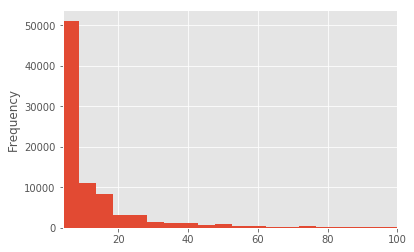

In [12]:
selected_compounds.plot.hist(xlim=[4,100],bins=1000)

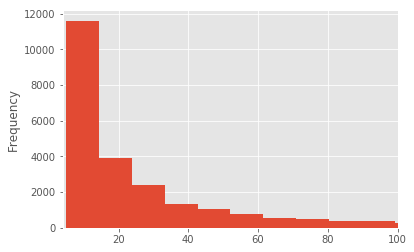

In [13]:
selected_heads.plot.hist(xlim=[4,100],bins=1000)

In [20]:
head_counts=modifiers.sum(axis=1).to_frame()
head_counts=head_counts/total_count
head_counts

0
modifier       decade      
a_n            8      0.000
abbey_n        8      0.000
               9      0.000
               11     0.000
               12     0.000
               13     0.000
               14     0.000
               16     0.000
               17     0.000
               18     0.000
abimelech_n    4      0.000
abolition_n    3      0.000
               4      0.000
               5      0.000
               8      0.000
               11     0.000
               12     0.000
               16     0.000
abolitionist_n 16     0.000
               20     0.000
abortion_n     13     0.000
               17     0.000
               18     0.000
               19     0.000
               20     0.000
absentee_n     17     0.000
absorption_n   16     0.000
ac_n           3      0.000
               6      0.000
acacia_n       2      0.000
...                     ...
yvie_n         9      0.000
zeal_n         2      0.000
               13     0.000
zemstvo_n      10     0.000
zero_n         18     0.000
zese_n         18     0.000
ziegfeld_n     12     0.000
               14     0.000
               15     0.000
               18     0.000
zigzag_n       4      0.000
               5      0.000
               8      0.000
               9      0.000
               12     0.000
               13     0.000
               15     0.000
               17     0.000
               19     0.000
               20     0.000
zinc_n         12     0.000
               13     0.000
               15     0.000
zone_n         16     0.000
               19     0.000
zoning_n       17     0.000
               19     0.000
zoom_n         17     0.000
               19     0.000
               20     0.000

[28225 rows x 1 columns]


## Handling Right side of compounds  : mod head right_context_1 right_context_2


rightgram=rightgram.groupby(['modifier','head','r1','r2','decade'])['freq'].sum().to_frame()
display(rightgram.shape)
rightgram.head(10)

compound_right_counts=pd.melt(rightgram.reset_index(),id_vars=['modifier','head','decade','freq'],value_vars=['r1','r2'])
compound_right=pd.pivot_table(compound_right_counts,index=['modifier','head','decade'],columns='value',values='freq',aggfunc=np.sum)
display(compound_right.shape)
compound_right.head(10)

mod_right_counts=pd.melt(rightgram.reset_index(),id_vars=['modifier','decade','freq'],value_vars=['head','r1'])
modifiers_right=pd.pivot_table(mod_right_counts,index=['modifier','decade'],columns='value',values='freq',aggfunc=np.sum)
display(modifiers_right.shape)
modifiers_right.head(10)

head_right_counts=pd.melt(rightgram.reset_index(),id_vars=['head','decade','freq'],value_vars=['r1','r2'])
heads_right=pd.pivot_table(head_right_counts,index=['head','decade'],columns='value',values='freq',aggfunc=np.sum)
display(heads_right.shape)
heads_right.head(10)

## Handling both sides of compounds : left_context_2 mod head right_context_1

midgram=fourgrams
midgram.columns=['freq','l2','modifier','head','r1','l2_PoS','mod_pos','head_pos','r1_PoS','decade']
midgram=cdsm_reducer(midgram,align="mid")
midgram=midgram.groupby(['modifier','head','l2','r1','decade'])['freq'].sum().to_frame()
display(midgram.shape)
midgram.head(10)

compound_mid_counts=pd.melt(midgram.reset_index(),id_vars=['modifier','head','decade','freq'],value_vars=['l2','r1'])
compound_mid=pd.pivot_table(compound_mid_counts,index=['modifier','head','decade'],columns='value',values='freq',aggfunc=np.sum)
display(compound_mid.shape)
compound_mid.head(10)

mod_mid_counts=pd.melt(midgram.reset_index(),id_vars=['modifier','decade','freq'],value_vars=['head','r1','l2'])
modifiers_mid=pd.pivot_table(mod_mid_counts,index=['modifier','decade'],columns='value',values='freq',aggfunc=np.sum)
display(modifiers_mid.shape)
modifiers_mid.head(10)

head_mid_counts=pd.melt(midgram.reset_index(),id_vars=['head','decade','freq'],value_vars=['modifier','l2','r1'])
heads_left=pd.pivot_table(head_left_counts,index=['head','decade'],columns='value',values='freq',aggfunc=np.sum)
display(heads_left.shape)
heads_left.head(10)

## Handling Left side of compounds  : left_context_1 left_context_2 mod head

leftgram=fourgrams
leftgram.columns=['freq','l1','l2','modifier','head','l1_PoS','l2_PoS','mod_pos','head_pos','decade']
leftgram=cdsm_reducer(leftgram,align="left")
leftgram=leftgram.groupby(['modifier','head','l1','l2','decade'])['freq'].sum().to_frame()
display(leftgram.shape)
leftgram.head(10)

compound_left_counts=pd.melt(leftgram.reset_index(),id_vars=['modifier','head','decade','freq'],value_vars=['l1','l2'])
compound_left=pd.pivot_table(compound_left_counts,index=['modifier','head','decade'],columns='value',values='freq',aggfunc=np.sum)
display(compound_left.shape)
compound_left.head(10)

mod_left_counts=pd.melt(leftgram.reset_index(),id_vars=['modifier','decade','freq'],value_vars=['l1','l2'])
modifiers_left=pd.pivot_table(mod_left_counts,index=['modifier','decade'],columns='value',values='freq',aggfunc=np.sum)
display(modifiers_left.shape)
modifiers_left.head(10)

head_left_counts=pd.melt(leftgram.reset_index(),id_vars=['head','decade','freq'],value_vars=['modifier','l2'])
heads_left=pd.pivot_table(head_left_counts,index=['head','decade'],columns='value',values='freq',aggfunc=np.sum)
display(heads_left.shape)
heads_left.head(10)

## Combining the left and right sides

compounds=pd.concat([compound_left_counts,compound_mid_counts,compound_right_counts])
compounds=pd.pivot_table(compounds,index=['modifier','head','decade'],columns='value',values='freq',aggfunc=np.sum)
display(compounds.shape)
compounds.head(10)

modifiers=pd.concat([mod_left_counts,mod_mid_counts,mod_right_counts])
modifiers=pd.pivot_table(modifiers,index=['modifier','decade'],columns='value',values='freq',aggfunc=np.sum)
display(modifiers.shape)
modifiers.head(10)

heads=pd.concat([head_left_counts,head_mid_counts,head_right_counts])
heads=pd.pivot_table(heads,index=['head','decade'],columns='value',values='freq',aggfunc=np.sum)
display(heads.shape)
heads.head(10)

display(modifiers.sum(axis=0).describe())
display(modifiers.sum(axis=1).describe())

modifier_svd = TruncatedSVD(n_components=300, n_iter=10, random_state=1991)
display(modifier_svd.fit(modifiers).explained_variance_ratio_.sum())
modifiers_reduced = modifier_svd.fit_transform(modifiers)
modifiers_reduced = Normalizer(copy=False).fit_transform(modifiers_reduced)
modifiers_reduced=pd.DataFrame(modifiers_reduced,index=modifiers.index)
modifiers_reduced


tot_head_count=np.nansum(heads)
heads=heads.applymap(lambda x: x/tot_head_count)
heads["sum"]=heads.sum(axis=1)
heads[heads.columns[:-1]]=heads[heads.columns[:-1]]/(heads[heads.columns[:-1]].sum(axis=0)**0.75)
heads=heads.drop('sum',axis=1).div(heads["sum"], axis=0)
heads=heads.applymap(lambda x:np.log2(x))
heads=heads.fillna(0)
heads[heads<0]=0
heads

tot_mod_count=np.nansum(modifiers)
modifiers=modifiers.applymap(lambda x: x/tot_mod_count)
modifiers["sum"]=modifiers.sum(axis=1)
modifiers[modifiers.columns[:-1]]=modifiers[modifiers.columns[:-1]]/(modifiers[modifiers.columns[:-1]].sum(axis=0)**0.75)
modifiers=modifiers.drop('sum',axis=1).div(modifiers["sum"], axis=0)
modifiers=modifiers.applymap(lambda x:np.log2(x))
modifiers=modifiers.fillna(0)
modifiers[modifiers<0]=0
modifiers

head_svd = TruncatedSVD(n_components=300, n_iter=10, random_state=1991)
display(head_svd.fit(heads).explained_variance_ratio_.sum())
heads_reduced = head_svd.fit_transform(heads)
heads_reduced = Normalizer(copy=False).fit_transform(heads_reduced)
heads_reduced=pd.DataFrame(heads_reduced,index=heads.index)
heads_reduced

modifiers.to_csv('modifiers.csv',sep="\t")
heads.to_csv('heads.csv',sep="\t")